# Plotting data from NetCDF files and calculating fluxes with MFT

In [268]:
import MFT
import numpy as np
import xarray as xr
import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots.declarative import (BarbPlot, FilledContourPlot, MapPanel, PanelContainer)
from tqdm.autonotebook import trange, tqdm

## Reading NetCDF file and calculating wind speed magnitude

### Creating Xarray Dataset from NetCDF file and getting Xarray DataArrays from the Dataset

In [269]:
# Open netCDF file

ds = xr.open_dataset('wrf_output.nc').metpy.parse_cf()
print(ds)

<xarray.Dataset>
Dimensions:    (lat: 99, lon: 99)
Coordinates:
  * lat        (lat) float32 32.76 32.85 32.95 33.04 ... 41.76 41.85 41.94 42.04
  * lon        (lon) float32 -79.25 -79.13 -79.0 -78.88 ... -67.27 -67.14 -67.02
    metpy_crs  object Projection: latitude_longitude
Data variables:
    UC         (lat, lon) float32 ...
    VC         (lat, lon) float32 ...
    U10        (lat, lon) float32 ...
    V10        (lat, lon) float32 ...
    SST        (lat, lon) float32 ...
    T2         (lat, lon) float32 ...
    Q2         (lat, lon) float32 ...
    SLP        (lat, lon) float32 ...
Attributes:
    Conventions:  None
    source_file:  wrfout_d02_2012-10-01_00:00:00
    title:        NCL generated netCDF file


In [270]:
# Get the 10m wind components

u10 = ds['U10']
v10 = ds['V10']
print(u10)
print(v10)

<xarray.DataArray 'U10' (lat: 99, lon: 99)>
[9801 values with dtype=float32]
Coordinates:
  * lat        (lat) float32 32.76 32.85 32.95 33.04 ... 41.76 41.85 41.94 42.04
  * lon        (lon) float32 -79.25 -79.13 -79.0 -78.88 ... -67.27 -67.14 -67.02
    metpy_crs  object Projection: latitude_longitude
Attributes:
    stagger:      
    units:        m s-1
    description:  U at 10 M
    MemoryOrder:  XY 
    FieldType:    104
    remap:        remapped via ESMF_regrid_with_weights: Bilinear remapping
<xarray.DataArray 'V10' (lat: 99, lon: 99)>
[9801 values with dtype=float32]
Coordinates:
  * lat        (lat) float32 32.76 32.85 32.95 33.04 ... 41.76 41.85 41.94 42.04
  * lon        (lon) float32 -79.25 -79.13 -79.0 -78.88 ... -67.27 -67.14 -67.02
    metpy_crs  object Projection: latitude_longitude
Attributes:
    stagger:      
    units:        m s-1
    description:  V at 10 M
    MemoryOrder:  XY 
    FieldType:    104
    remap:        remapped via ESMF_regrid_with_weights: Bil

In [271]:
# Calculate the wind speed (this is just a shortcut for sqrt(u^2 + v^2))

ds['wind_speed'] = mpcalc.wind_speed(ds['U10'], ds['V10'])
print(ds['wind_speed'])

<xarray.DataArray 'wind_speed' (lat: 99, lon: 99)>
<Quantity([[      nan       nan       nan ...       nan       nan       nan]
 [      nan       nan       nan ...       nan       nan       nan]
 [      nan       nan       nan ...       nan       nan       nan]
 ...
 [      nan 1.9714457 1.90234   ...       nan       nan       nan]
 [      nan 2.075788  1.9514558 ...       nan       nan       nan]
 [      nan       nan       nan ...       nan       nan       nan]], 'meter / second')>
Coordinates:
  * lat        (lat) float32 32.76 32.85 32.95 33.04 ... 41.76 41.85 41.94 42.04
  * lon        (lon) float32 -79.25 -79.13 -79.0 -78.88 ... -67.27 -67.14 -67.02
    metpy_crs  object Projection: latitude_longitude


### Plotting 10m Wind

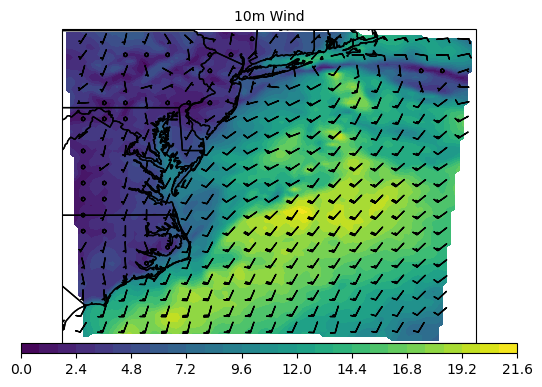

In [272]:
# Set attributes for plotting color-filled contours of wind speed
cfill = FilledContourPlot()
cfill.data = ds
cfill.field = 'wind_speed'
cfill.colorbar = 'horizontal'
cfill.plot_units = 'knot'

# Set attributes for plotting wind barbs
barbs = BarbPlot()
barbs.data = ds
barbs.field = ['U10', 'V10']
barbs.barblength = 4
barbs.skip = (5, 5)
barbs.plot_units = 'knot'

# Set the attributes for the map and add our data to the map
panel = MapPanel()
panel.layers = ['states', 'coastline', 'borders']
panel.title = f'10m Wind'
panel.plots = [cfill, barbs]

# Set the attributes for the panel and put the panel in the figure
pc = PanelContainer()
pc.panels = [panel]

# Show the plot
pc.show()


## Multi-Flux Testbed (MFT)

### Calculating Fluxes

In [273]:
# MFT Parameters

CONV_CRIT = 0.00005     #convergence critereon (fractional change)  []  
CONVECT = 0.0          #convective parameter  
warn = 1                #warning are given     
eqv_neut = 0            #output winds are winds rather than equivalent neutral winds  
z_wanted = 10.0         #height to which winds, potential temp, and humidity are adjusted                                
flux_model = 9          #BVW model=0  
Qnet = 5.0
sst_prm = 0
z0_mom_prm = 0
z0_TQ_prm = 0
stable_prm = 0
wind_ang = 0
wave_ang = 0

dyn_in_prm = 0 # Wind speed, relative to the surface current, m/s
dyn_in_val2 = 0.0
ref_ht_wind = 10.0 # Height of the wind observations, m
CONVECT = 0 # Convective parameter. Recommended value between 0.7 and 1.25. For details see TOGA NOTES #4 (recommendation comes from no capillary waves)
air_moist_prm = 0 # Relative humidity, specific humidity
sfc_moist_prm = 1 # Relative humidity, fraction
sfc_moist_val = 0.98 # 98% assumed because of salinity obstructing evaporation
salinity = 34.9 / 1000.0 # Salinity, fraction, No salinity in dataset (global average)
ss_prm = 0 # Sea state parameterization, wind-wave stability parameter
ss_val = 1.0 # No sea state data in dataset, set to 1.0 for local equilibrium
ref_ht_tq = 2 # Height of temperature and humidity observations, m
sst_prm = 0 # Designates surface temperature as skin temperature?
astab = 1 # Atmospheric stability is calculated

In [274]:
# Calculate stress with MFT

stress = np.ma.masked_all_like(ds['wind_speed'])

for (x,y), s in tqdm(np.ndenumerate(stress), total=len(stress.flatten())):
	index = (x,y)

	if not np.isnan(float(ds['SST'][index].values)):
		dyn_in_val = ds['wind_speed'][index].metpy.quantify().data.to('m/s').m
		pressure = ds['SLP'][index].metpy.quantify().data.to('Pa').m # Atmospheric surface pressure, Pa (converted from hPa in dataset)
		air_moist_val = ds['Q2'][index].metpy.quantify().data.to('kg/kg').m # (converted from g/kg to fraction)
		t_air = ds['T2'][index].metpy.quantify().data.to('degC').m # Air temperature at the reference height of the thermometer and humidity sensor, C
		t_skin =ds['SST'][index].metpy.quantify().data.to('degC').m # skin tempearture, C
		
		pass_by_ref_params = {'shf':0, 'lhf':0, 'tau':[0,0], 'u_star':[0,0], 't_star':0, 'q_star':0, 'z_over_L':0, 'wave_age':0, 'dom_phs_spd':0,
			'h_sig':0, 'ww_stab':0, 'zo_m':[0, 0], 'u_at_z':0, 't_at_z':0, 'q_at_z':0}

		count = MFT.ht_adj_( dyn_in_prm, dyn_in_val, dyn_in_val2, CONVECT, CONV_CRIT,
			pressure, air_moist_prm, air_moist_val, sfc_moist_prm, sfc_moist_val,
			salinity, ss_prm, ss_val, t_air, sst_prm, t_skin, ref_ht_wind, ref_ht_tq,
			z_wanted, astab, eqv_neut, Qnet, warn, flux_model, z0_mom_prm, z0_TQ_prm, stable_prm,
			pass_by_ref_params )
		if count > 0:
			stress[index] = pass_by_ref_params["tau"][0]

ds['tau'] = xr.DataArray(
	data=stress * units('N m^-2'),
	dims=ds.dims,
	coords=ds.coords,
	attrs=dict(
		description="Wind stress",
		),
)
print(ds['tau'])

  0%|          | 0/9801 [00:00<?, ?it/s]

<xarray.DataArray 'tau' (lat: 99, lon: 99)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan, 0.00091838, 0.0008505 , ...,        nan,        nan,
               nan],
       [       nan, 0.00102596, 0.00089823, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
  * lat        (lat) float32 32.76 32.85 32.95 33.04 ... 41.76 41.85 41.94 42.04
  * lon        (lon) float32 -79.25 -79.13 -79.0 -78.88 ... -67.27 -67.14 -67.02
    metpy_crs  object Projection: latitude_longitude
Attributes:
    description:  Wind stress


### Plotting Fluxes

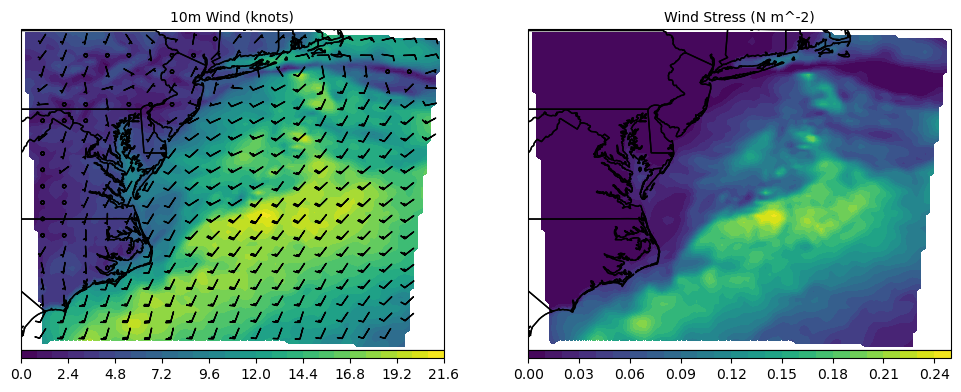

In [275]:
# Set attributes for plotting color-filled contours of wind speed
cfill = FilledContourPlot()
cfill.data = ds
cfill.field = 'wind_speed'
cfill.colorbar = 'horizontal'
cfill.plot_units = 'knot'

# Set attributes for plotting wind barbs
barbs = BarbPlot()
barbs.data = ds
barbs.field = ['U10', 'V10']
barbs.barblength = 4
barbs.skip = (5, 5)
barbs.plot_units = 'knot'

# Set attributes for plotting color-filled contours of wind stress
cfill2 = FilledContourPlot()
cfill2.data = ds
cfill2.field = 'tau'
cfill2.colorbar = 'horizontal'

# Set the attributes for the map and add our data to the map
panel1 = MapPanel()
panel1.layout = (1, 2, 1)
panel1.layers = ['states', 'coastline', 'borders']
panel1.title = f'10m Wind (knots)'
panel1.plots = [cfill, barbs]

panel2 = MapPanel()
panel2.layout = (1, 2, 2)
panel2.layers = ['states', 'coastline', 'borders']
panel2.title = f'Wind Stress (N m^-2)'
panel2.plots = [cfill2]

# Set the attributes for the panel and put the panel in the figure
pc = PanelContainer()
pc.size = (12,6)
pc.panels = [panel1, panel2]

# Show the plot
pc.show()